In [1]:
import matplotlib.pyplot as plt
from tools.tools import save2nc
import tools.config as config

import seaborn as sns
sns.set_theme(style="whitegrid")  # 推荐

def create_mask(years, base_path,env_category,env_name, chunks="auto"):
    masks = []
    for y in years:
        data_tmpl = f"{base_path}/{env_category}/{y}/xr_total_{env_category}_{y}.nc"
        data_xr  = xr.open_dataarray(data_tmpl.format(year=y), chunks=chunks)
        cost_tml = f"{base_path}/{env_category}/{y}/xr_{env_name}_{y}.nc"
        cost_xr = xr.open_dataarray(cost_tml.format(year=y), chunks=chunks)
        m = (data_xr >= 1) & (cost_xr >= 1)
        masks.append(m.expand_dims(year=[y]))
    mask = xr.concat(masks, dim="year")
    mask.name = "mask"
    mask.attrs["description"] = "True if both env and cost >= 1, else False"
    return mask

def create_xarray(years, base_path, env_category, env_name,mask=None,
                  engine="h5netcdf",
                  cell_dim="cell", cell_chunk="auto",
                  year_chunk=1, parallel=False):
    """
    以 year 维度拼接多个年度 NetCDF，懒加载+分块，避免过多文件句柄。
    """
    file_paths = [
        os.path.join(base_path, str(env_category), str(y), f"xr_{env_name}_{y}.nc")
        for y in years
    ]
    missing = [p for p in file_paths if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(f"以下文件未找到:\n" + "\n".join(missing))

    # 从文件名提取实际年份，确保坐标与文件顺序一致
    valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in file_paths]

    ds = xr.open_mfdataset(
        file_paths,
        engine=engine,
        combine="nested",          # 明确“按给定顺序拼接”
        concat_dim="year",         # 新增 year 维度
        parallel=parallel,         # 一般 False 更稳，避免句柄并发
        chunks={cell_dim: cell_chunk, "year": year_chunk}  # year=1，cell 分块
    ).assign_coords(year=valid_years)
    
    if mask is not None:
        ds = ds.where(mask, other=0)  # 使用掩码，非掩码区域设为 0

    return ds

import os
import xarray as xr
from joblib import Parallel, delayed


def process_file(file_path, year_idx, cat, mask_year=None):
    """
    处理单个文件：加载 -> (可选)按当年mask筛选 -> 对所有非year维求和 -> 返回 year 维标量
    """
    print(f"Processing {file_path}")
    ds_one = xr.open_dataset(file_path, chunks="auto")
    main_var = next(iter(ds_one.data_vars))
    da = ds_one[main_var]

    # 如果给了当年的 mask，先对齐再筛选
    if mask_year is not None:
        # 对齐到共同维度（一般是 cell）
        da, mask_year = xr.align(da, mask_year, join="inner")
        da = da.where(mask_year)

    # 对除 "year" 以外的所有维求和成一个标量
    reduce_dims = [d for d in da.dims if d != "year"]
    s = da.sum(dim=reduce_dims)

    # 保证是标量（如果还带着year坐标，取该年的值）
    if "year" in s.dims:
        s = s.sel(year=year_idx)

    return xr.Dataset({cat: xr.DataArray([s], dims=["year"], coords={"year": [year_idx]})})


def create_cost_year_series(
    years,
    base_path,
    env_category,
    mask=None,                 # <- 新增：可选的 (year, cell) 布尔mask
    year_chunk=-1,
    parallel=True,
    cost_categories=("cost_ag",
                     "cost_agricultural_management",
                     "cost_non_ag",
                     "cost_transition_ag2ag_diff",
                     "transition_cost_ag2non_ag_amortised_diff"),
    finalize="compute",        # "lazy" | "persist" | "compute"
):
    """
    对每个 cost_category:
      - 逐文件打开，(可选)应用 mask(year, cell)
      - 将所有非year维求和成标量
      - 拼出 1D 年序列
    合并所有 cost_category，并追加 TOTAL。
    返回：
      da_year: DataArray, 维度 (cost_category, year)，含 'TOTAL'
    """

    # 如果提供了 mask，限定有效年份为交集（避免 mask 没有的年份报错）
    years = list(years)
    if mask is not None:
        mask_years = set(mask.coords["year"].values.tolist())
        years_in_both = [y for y in years if y in mask_years]
        if not years_in_both:
            raise ValueError("提供的 mask 不包含任何所需年份。")
        if len(years_in_both) != len(years):
            missing = sorted(set(years) - set(years_in_both))
            print(f"[WARN] 这些年份不在mask中，将跳过：{missing}")
        years = years_in_both

    per_cat_ds = []

    for cat in cost_categories:
        # 生成文件路径
        paths = [os.path.join(base_path, str(env_category), str(y),
                              f"xr_{cat}_{env_category}_{y}.nc")
                 for y in years]
        exist = [p for p in paths if os.path.exists(p)]
        if not exist:
            raise FileNotFoundError(f"未找到 {cat} 的 NetCDF 文件。")

        # 文件对应的年份
        valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in exist]

        # 为并行准备每年的当年mask切片（若有）
        mask_slices = None
        if mask is not None:
            # 确保 mask 是按年可索引的
            mask_slices = {y: mask.sel(year=y) for y in valid_years}

        # 并行或串行处理
        if parallel:
            ds_list = Parallel(n_jobs=-1, backend="loky")(
                delayed(process_file)(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            )
        else:
            ds_list = [
                process_file(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            ]

        # 沿 year 维拼接
        ds_cat = xr.concat(ds_list, dim="year").assign_coords(year=valid_years)
        if year_chunk > 0 and finalize != "compute":
            ds_cat = ds_cat.chunk({"year": year_chunk})
        per_cat_ds.append(ds_cat)

    # 合并所有 cost_category -> (cost_category, year)
    ds_year = xr.merge(per_cat_ds, compat="override", join="exact")
    da_year = ds_year.to_array(dim="cost_category").transpose("cost_category", "year")

    # 追加 TOTAL
    da_total = da_year.sum(dim="cost_category", skipna=True).expand_dims(cost_category=["TOTAL"])
    da_year = xr.concat([da_year, da_total], dim="cost_category")

    # 计算策略
    if finalize == "compute":
        return da_year.compute()
    if finalize == "persist":
        return da_year.persist()
    return da_year


def quick_plot(da, title, figure_path):

    fig, ax = plt.subplots(figsize=(5, 4))

    # 1. 找出用于分类的维度 (hue)
    cat_dims = [d for d in da.dims if d != "year"]
    if not cat_dims:
        raise ValueError("DataArray must have a dimension other than 'year' to use for hue.")
    hue_dim = cat_dims[0]

    # 2. 【关键改变】我们自己写循环，遍历 hue 维度中的每一个类别
    for category in da[hue_dim].values:
        # a. 选择出当前类别的数据
        data_for_category = da.sel({hue_dim: category})
        
        # b. 为这个类别单独画一条线，并在这里【显式地】为它设置 label
        data_for_category.plot.line(
            ax=ax,
            x="year",
            marker='o',
            linestyle='-',
            markersize=4,
            label=str(category)  # <-- 最重要的部分！
        )

    # 3. 设置坐标轴和标题
    ax.set(ylabel='', title=title, xlabel='')

    # 4. 现在，所有线条都已画好，且每条线都有一个明确的 label
    #    ax.legend() 可以成功找到它们，并按我们的要求放置图例。
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue_dim)
    
    # 5. 使用 bbox_inches='tight' 保存图像，确保外部图例被完整包含。
    figure_name = f"{title}.png"
    plt.savefig(os.path.join(figure_path, figure_name), bbox_inches='tight', pad_inches=0.1)
    
    plt.show()



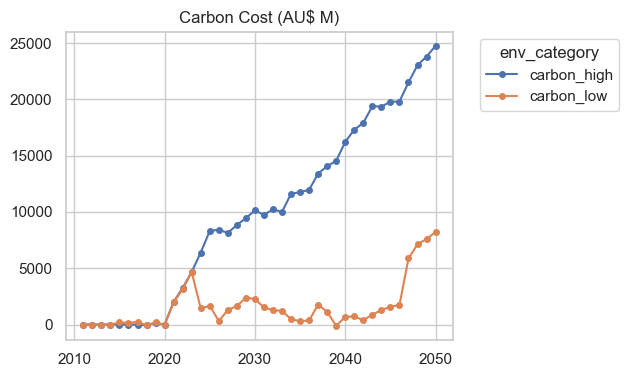

In [2]:
import os
task_name = config.TASK_NAME
base_path = f"../../../output/{task_name}/carbon_price/0_base_data"
excel_path = f"../../../output/{task_name}/carbon_price/1_excel"
figure_path = f"../../../output/{task_name}/carbon_price/2_figure"
os.makedirs(excel_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

env_categorys = ["carbon_high","carbon_low"]
years = list(range(2011, 2051))

# 1) 收集所有 DataArray
all_costs = []
for env_category in env_categorys:
    env_name = f"total_cost_{env_category}_amortised"
    xr_carbon_cost = create_xarray(years, base_path, env_category, env_name)  # dims: (year, cell)
    all_costs.append(xr_carbon_cost)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_carbon_cost = xr.concat(all_costs, dim="env_category")
xr_all_carbon_cost = xr_all_carbon_cost.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签

# 3) 直接在 cell 维度上求和
xr_all_carbon_cost_sum = xr_all_carbon_cost.sum(dim="cell").compute()  # dims: (env_category, year)
da=xr_all_carbon_cost_sum["data"]/1e6
quick_plot(da, "Carbon Cost (AU$ M)", figure_path)

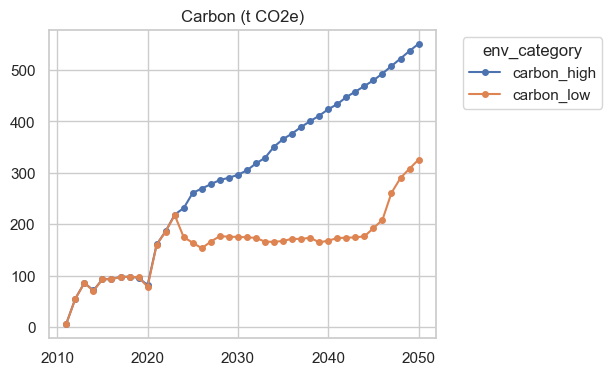

In [3]:
# 1) 收集所有 DataArray
all_costs = []
for env_category in env_categorys:
    env_name = f"total_{env_category}"
    xr_carbon_cost = create_xarray(years, base_path, env_category, env_name)  # dims: (year, cell)
    all_costs.append(xr_carbon_cost)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_carbon = xr.concat(all_costs, dim="env_category")
xr_all_carbon = xr_all_carbon.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签

# 3) 直接在 cell 维度上求和
xr_all_carbon_sum = xr_all_carbon.sum(dim="cell").compute()  # dims: (env_category, year)
da=xr_all_carbon_sum["data"]/1e6
quick_plot(da, "Carbon (t CO2e)", figure_path)

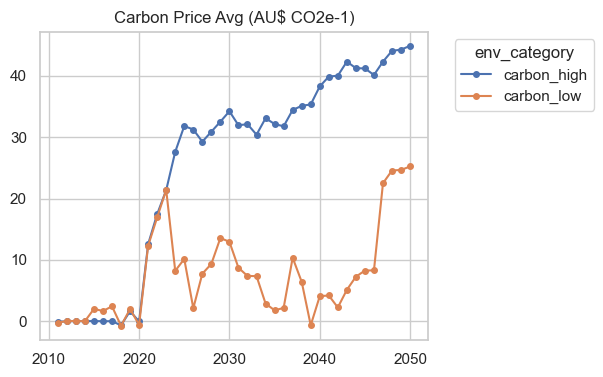

In [4]:
xr_all_carbon_price_avg=xr_all_carbon_cost_sum/xr_all_carbon_sum
da=xr_all_carbon_price_avg["data"]
quick_plot(da, "Carbon Price Avg (AU$ CO2e-1)", figure_path)

In [5]:
import numpy as np
xr_all_carbon_price_avg=xr_all_carbon_cost_sum/xr_all_carbon_sum
ds=xr_all_carbon_price_avg
# 2. 使用 groupby_bins 对 'year' 维度进行分组，然后对每个组求和
bins = np.arange(2010, 2051, 5)

# 2. 分组并求和 (这部分不变)
five_year_sum_ds = ds.groupby_bins('year', bins=bins).sum()

# 3. 重命名坐标 (这部分不变)
five_year_sum_ds = five_year_sum_ds.rename({'year_bins': 'year_start'})

# --- 这是修正的部分 ---
# 4. 提取并转换坐标值
#    从坐标 'year_start' 中获取 interval 对象数组
interval_values = five_year_sum_ds.year_start.values

#    使用列表推导式从每个 interval 中提取起始年份
start_years = [interval.left for interval in interval_values]

#    将新生成的年份列表赋值回坐标
five_year_sum_ds['year_start'] = start_years
# --- 修正结束 ---

print(five_year_sum_ds)

<xarray.Dataset> Size: 216B
Dimensions:       (year_start: 8, env_category: 2)
Coordinates:
  * env_category  (env_category) <U11 88B 'carbon_high' 'carbon_low'
  * year_start    (year_start) int64 64B 2010 2015 2020 2025 2030 2035 2040 2045
Data variables:
    data          (year_start, env_category) float32 64B -0.1509 1.76 ... 105.2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


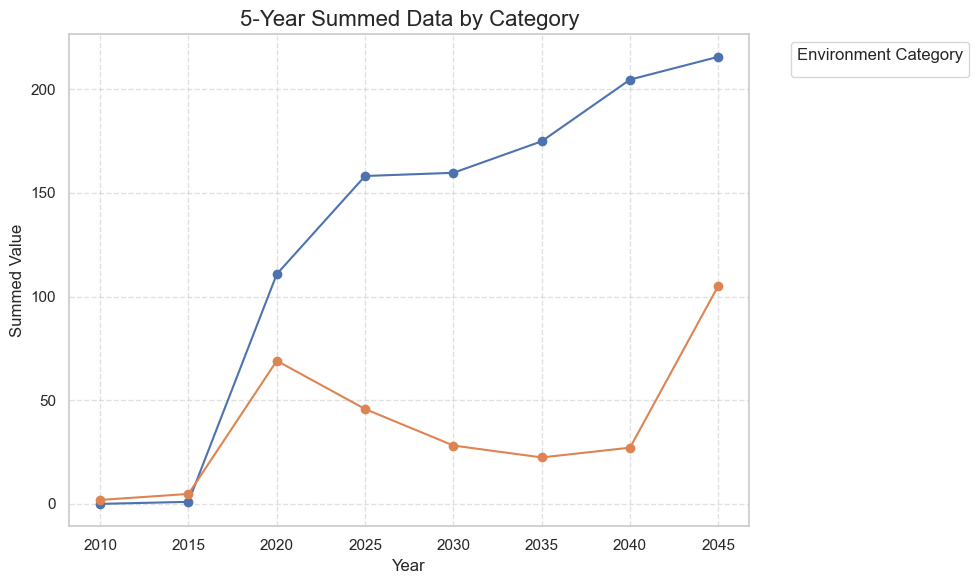

In [6]:
# --- 2. 开始绘图 ---
fig, ax = plt.subplots(figsize=(10, 6))

# 使用 xarray 自带的 plot 功能
# x='year_start' -> 指定 x 轴
# hue='env_category' -> 让 xarray 为每个 env_category 画一条不同颜色的线，并自动生成图例
five_year_sum_ds['data'].plot.line(
    ax=ax,
    x='year_start',
    hue='env_category',
    marker='o',          # 为每个数据点添加一个标记，因为数据点不多
    linestyle='-'
)

# --- 3. 美化图表 ---
ax.set_title("5-Year Summed Data by Category", fontsize=16)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Summed Value", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) # 添加网格线，方便阅读

# 调整图例位置，避免遮挡
ax.legend(title='Environment Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# 确保所有元素都能正常显示
plt.tight_layout()

# 显示图像
plt.show()

In [7]:
# 1) 收集所有 DataArray
all_masks = []
for env_category in env_categorys:
    env_name = f"total_cost_{env_category}_amortised"
    xr_mask = create_mask(years, base_path, env_category, env_name)  # dims: (year, cell)
    all_masks.append(xr_mask)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_carbon_masks = xr.concat(all_masks, dim="env_category")
xr_all_carbon_masks = xr_all_carbon_masks.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签
xr_all_carbon_price=xr_all_carbon_cost/xr_all_carbon*xr_all_carbon_masks

In [8]:
def draw_line_plot(q,xr_array,tile_name):
    """
    画出各 env_category 在各年份的 q 分位数
    """
     # 直接在 cell 维度上求 q 分位数
    qs = xr_array['data'].quantile(q=q, dim="cell", skipna=True)  # (env_category, year)
    qs = qs.transpose("year", "env_category")
    
    fig, ax = plt.subplots(figsize=(8,5))
    qs.plot.line(
        x="year", 
        hue="env_category",   # 图例用 env_category 名字
        ax=ax,
        marker="o", linestyle="-", markersize=4
    )
    
    ax.set(ylabel="", title=f"{q*100}th {tile_name}")
    # 手动从坐标轴里取到 line 句柄，并配上 env_category 名称
    labels = [str(v) for v in qs.coords["env_category"].values]
    handles = ax.get_lines()[:len(labels)]
    
    ax.legend(handles, labels, title="env_category",
              bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


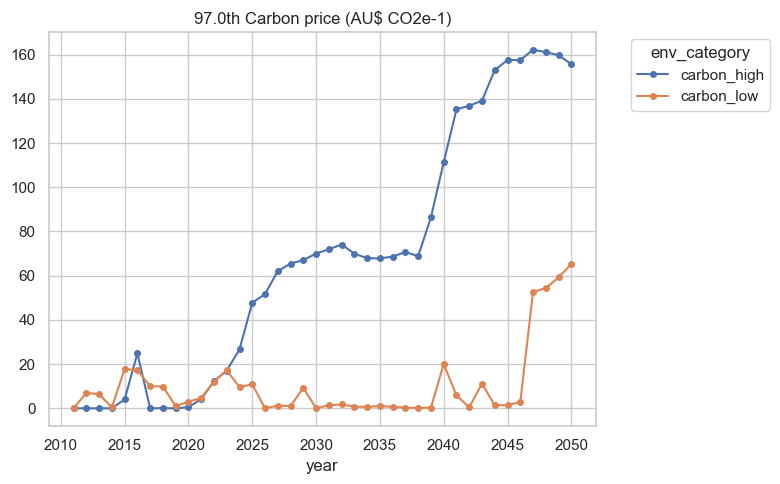

In [9]:
q = 0.97
draw_line_plot(q, xr_all_carbon_price,'Carbon price (AU$ CO2e-1)')

In [10]:
save2nc(xr_all_carbon_cost, os.path.join(base_path, 'Results', "xr_carbon_cost_scenario_cell.nc"))
save2nc(xr_all_carbon, os.path.join(base_path, 'Results', "xr_carbon_scenario_cell.nc"))
save2nc(xr_all_carbon_cost_sum, os.path.join(base_path, 'Results', "xr_carbon_cost_scenario_sum.nc"))
save2nc(xr_all_carbon_sum, os.path.join(base_path, 'Results', "xr_carbon_scenario_sum.nc"))

save2nc(xr_all_carbon_price, os.path.join(base_path, 'Results', "xr_carbon_price_scenario_cell.nc"))
save2nc(xr_all_carbon_masks, os.path.join(base_path, 'Results', "xr_carbon_masks_scenario_cell.nc"))
save2nc(xr_all_carbon_price_avg, os.path.join(base_path, 'Results', "xr_carbon_price_scenario_avg.nc"))

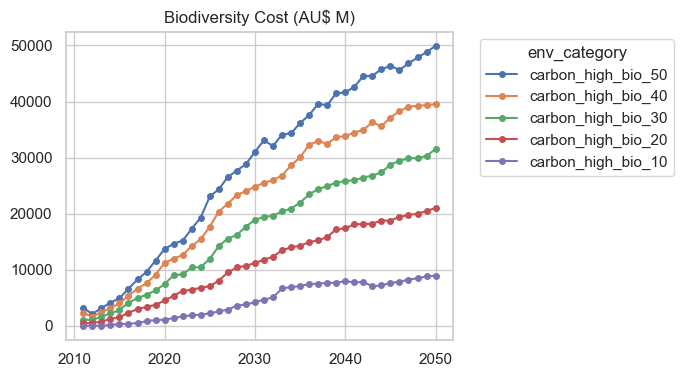

In [11]:
env_categorys = ["carbon_high_bio_50","carbon_high_bio_40","carbon_high_bio_30","carbon_high_bio_20","carbon_high_bio_10"]
years = list(range(2011, 2051))

# 1) 收集所有 DataArray
all_costs = []
for env_category in env_categorys:
    env_name = f"total_cost_{env_category}_amortised"
    xr_bio_mask = create_mask(years, base_path,env_category, env_name)
    xr_carbon_cost = create_xarray(years, base_path, env_category, env_name, xr_bio_mask)  # dims: (year, cell)
    all_costs.append(xr_carbon_cost)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_bio_cost = xr.concat(all_costs, dim="env_category")
xr_all_bio_cost = xr_all_bio_cost.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签

# 3) 直接在 cell 维度上求和
xr_all_bio_cost_sum = xr_all_bio_cost.sum(dim="cell").compute() 
da=xr_all_bio_cost_sum["data"]/1e6
quick_plot(da, "Biodiversity Cost (AU$ M)", figure_path)

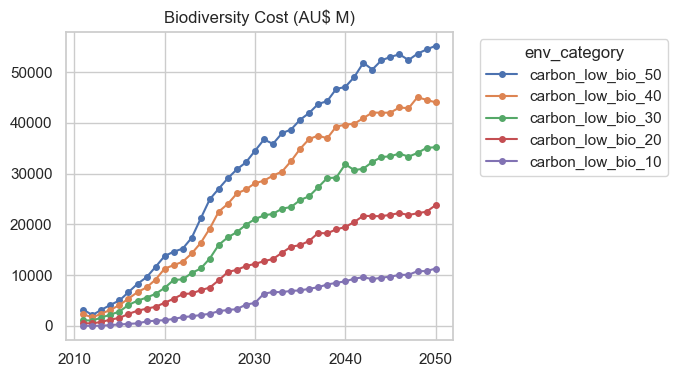

In [12]:

env_categorys = ["carbon_low_bio_50","carbon_low_bio_40","carbon_low_bio_30","carbon_low_bio_20","carbon_low_bio_10"]
years = list(range(2011, 2051))

# 1) 收集所有 DataArray
all_costs = []
for env_category in env_categorys:
    env_name = f"total_cost_{env_category}_amortised"
    xr_bio_mask = create_mask(years, base_path,env_category, env_name)
    xr_carbon_cost = create_xarray(years, base_path, env_category, env_name, xr_bio_mask)  # dims: (year, cell)
    all_costs.append(xr_carbon_cost)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_bio_cost = xr.concat(all_costs, dim="env_category")
xr_all_bio_cost = xr_all_bio_cost.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签

# 3) 直接在 cell 维度上求和
xr_all_bio_cost_sum = xr_all_bio_cost.sum(dim="cell").compute() 
da=xr_all_bio_cost_sum["data"]/1e6
quick_plot(da, "Biodiversity Cost (AU$ M)", figure_path)

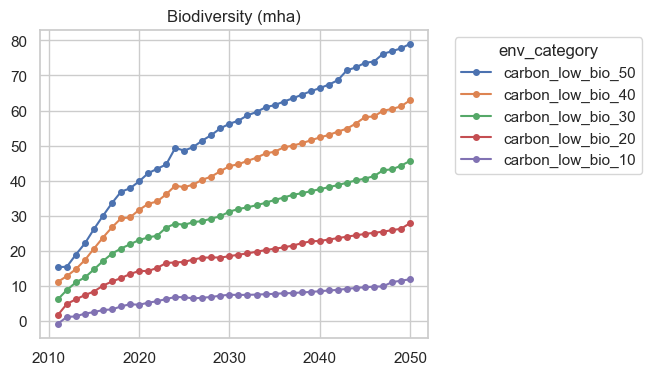

In [13]:
# 1) 收集所有 DataArray
all_bio = []
for env_category in env_categorys:
    env_name = f"total_{env_category}"
    xr_bio = create_xarray(years, base_path, env_category, env_name)  # dims: (year, cell)
    all_bio.append(xr_bio)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_bio_all = xr.concat(all_bio, dim="env_category")
xr_bio_all = xr_bio_all.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签

# 3) 直接在 cell 维度上求和
xr_bio_all_sum = xr_bio_all.sum(dim="cell").compute()  # dims: (env_category, year)
da=xr_bio_all_sum["data"]/1e6
quick_plot(da, "Biodiversity (mha)", figure_path)

In [14]:
# 1) 收集所有 DataArray
all_masks = []
for env_category in env_categorys:
    env_name = f"total_cost_{env_category}_amortised"
    xr_mask = create_mask(years, base_path, env_category, env_name)  # dims: (year, cell)
    all_masks.append(xr_mask)

# 2) 合并到一个 DataArray，新增维度 env_category
xr_all_bio_masks = xr.concat(all_masks, dim="env_category")
xr_all_bio_masks = xr_all_bio_masks.assign_coords(env_category=env_categorys)  # 给 env_category 维加上标签
xr_all_bio_price=xr_all_bio_cost/xr_bio_all*xr_all_bio_masks

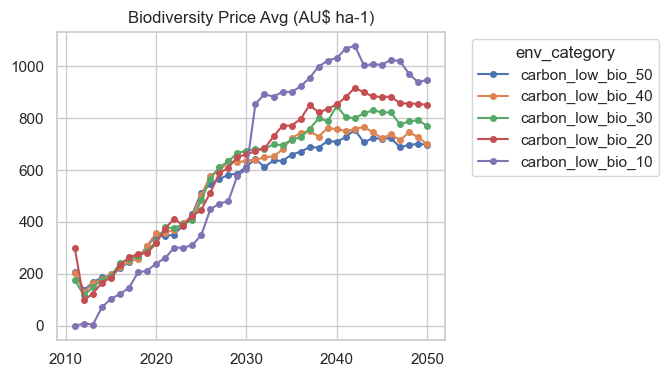

In [15]:
xr_all_bio_price_avg=xr_all_bio_cost_sum/xr_bio_all_sum
da=xr_all_bio_price_avg["data"]
quick_plot(da, "Biodiversity Price Avg (AU$ ha-1)", figure_path)

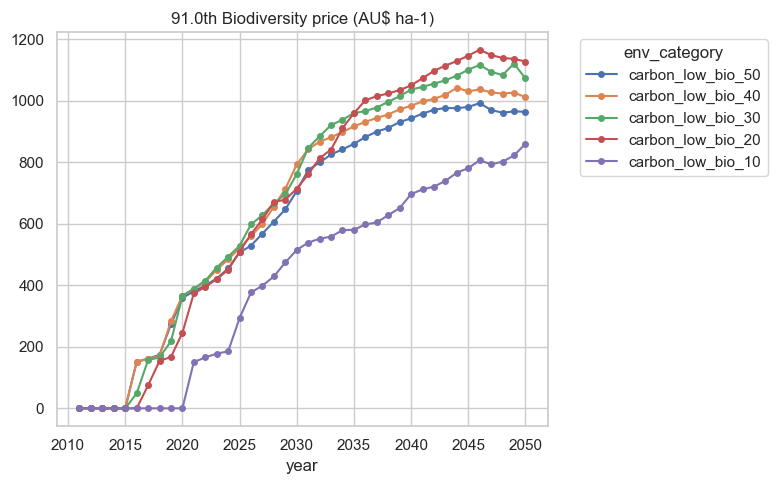

In [16]:
q = 0.91
draw_line_plot(q, xr_all_bio_price,"Biodiversity price (AU$ ha-1)")

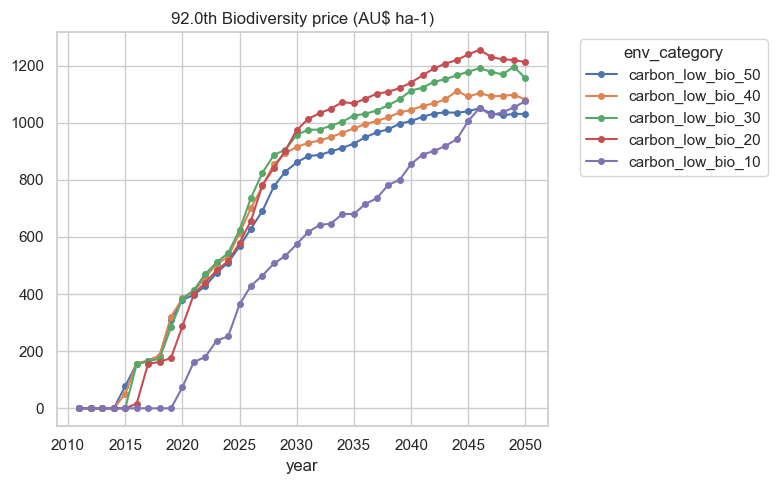

In [17]:
q = 0.92
draw_line_plot(q, xr_all_bio_price,"Biodiversity price (AU$ ha-1)")

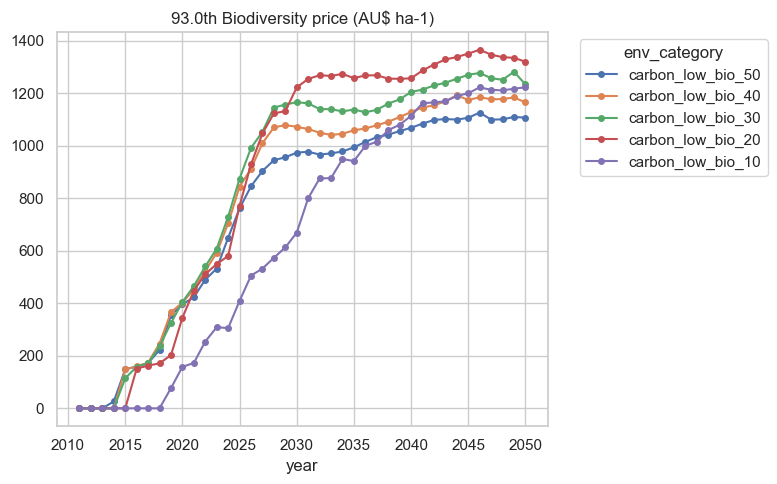

In [18]:
q = 0.93
draw_line_plot(q, xr_all_bio_price,"Biodiversity price (AU$ ha-1)")

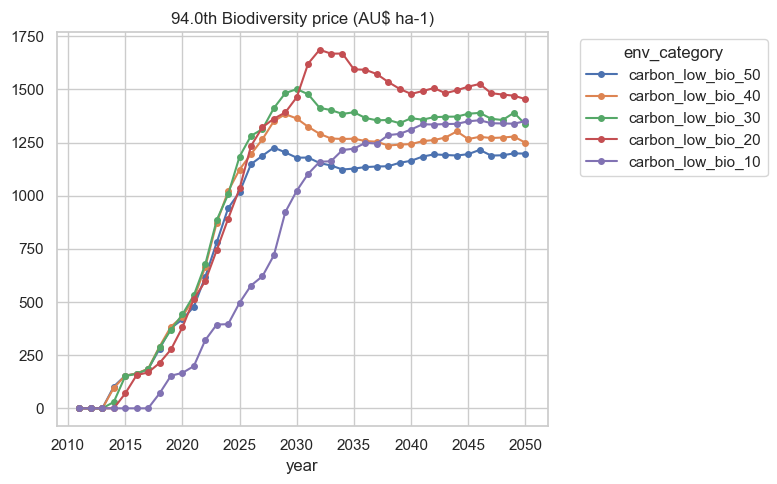

In [19]:
q = 0.94
draw_line_plot(q, xr_all_bio_price,"Biodiversity price (AU$ ha-1)")

In [20]:
save2nc(xr_all_bio_cost, os.path.join(base_path, 'Results', "xr_bio_cost_scenario_cell.nc"))
save2nc(xr_bio_all, os.path.join(base_path, 'Results', "xr_bio_scenario_cell.nc"))
save2nc(xr_all_bio_cost_sum, os.path.join(base_path, 'Results', "xr_bio_cost_scenario_sum.nc"))
save2nc(xr_bio_all_sum, os.path.join(base_path, 'Results', "xr_bio_scenario_sum.nc"))

save2nc(xr_all_bio_price, os.path.join(base_path, 'Results', "xr_bio_price_scenario_cell.nc"))
save2nc(xr_all_bio_masks, os.path.join(base_path, 'Results', "xr_bio_masks_scenario_cell.nc"))
save2nc(xr_all_bio_price_avg, os.path.join(base_path, 'Results', "xr_bio_price_scenario_avg.nc"))


In [21]:
xr_all_bio_price.sel(year=2050,env_category='carbon_high_bio_50')

KeyError: "not all values found in index 'env_category'. Try setting the `method` keyword argument (example: method='nearest')."